NLP

In [ ]:
#!pip install "la-core-web-lg @ https://huggingface.co/latincy/la_core_web_lg/resolve/main/la_core_web_lg-any-py3-none-any.whl"

In [5]:
# Using spacy.load().
import spacy
from spacy import Language
from spacy.lookups import Lookups
nlp = spacy.load("la_core_web_lg")

In [2]:
import json

with open("stopwords_latin.json", "r", encoding="utf-8") as f:
    stopwords_json = json.load(f)

latin_stopwords = set()

for category, items in stopwords_json.items():
    if isinstance(items, list):
        # Case 1: Simple list of stopwords
        latin_stopwords.update(word.lower() for word in items)
    elif isinstance(items, dict):
        # Case 2: Nested dictionary (e.g., "Pronouns")
        for lemma, forms in items.items():
            latin_stopwords.add(lemma.lower())                     # include the lemma
            latin_stopwords.update(word.lower() for word in forms) # include all word forms

In [3]:
token = nlp("ablatus")[0]
print(token.lemma_) #returns incorrect lemma (ablatus) before custom lemma lookup

ablatus


In [7]:
#create custom lemma lookup for 'inquit'

lookups = Lookups()

custom_lemma_lookups = {
    "inquam": ["inquit"],
    "aufero": ["ablatus"]
}

custom_lookups = {}
for key, values in custom_lemma_lookups.items():
    for value in values:
        if value not in lookups:
            custom_lookups[value] = key

@Language.component(name="custom_lookup_lemmatizer")
def make_lookup_lemmatizer_function(doc):
    for token in doc:
        token.lemma_ = custom_lookups.get(token.text, token.lemma_)
    return doc

try:
    nlp.add_pipe("custom_lookup_lemmatizer", name="custom_lookup_lemmatizer")
except:
    # If the pipeline component is already added, we can't add it again
    pass

In [8]:
def process_latin_text(text):
    doc = nlp(text)
    # Tokenize, lowercase, lemmatize
    tokens = [token.lemma_.lower() for token in doc if token.is_alpha and token.lemma_.lower() not in latin_stopwords and token.pos_ in ["PROPN", "NOUN", "VERB", "ADJ"]]
    return tokens

In [9]:
# Load the corpus
with open("latin_tragedies_corpus.json", "r", encoding="utf-8") as f:
    corpus = json.load(f)

# Process each text and store with title and author
processed_corpus = []
for tragedy in corpus:
    tokens = process_latin_text(tragedy["text"])
    processed_tragedy = {
        "title": tragedy["title"],
        "author": tragedy["author"],
        "tokens": tokens
    }
    processed_corpus.append(processed_tragedy)

# Now `processed_corpus` is a list of dictionaries like:
# {"title": "...", "author": "...", "tokens": [...]}

In [10]:
with open("processed_tragedies_corpus.json", "w", encoding="utf-8") as f:
    json.dump(processed_corpus, f, ensure_ascii=False, indent=2)

In [11]:
import pickle

# Save the processed corpus to a .pkl file to use in python
with open("processed_corpus.pkl", "wb") as f:
    pickle.dump(processed_corpus, f)


In [12]:
# Load the processed corpus from the .pkl file
with open("processed_corpus.pkl", "rb") as f:
    processed_corpus = pickle.load(f)

# access tokens directly
tokens_1 = processed_corpus[0]["tokens"]
print(type(tokens_1))  # Should be <class 'list'>

<class 'list'>


In [14]:
len(tokens_1)

2548

In [13]:
tragedy_title = processed_corpus[0]['title']
print(tragedy_title)

Phoenissae


### CountVectorizer, TF-IDF, and Cosine Similarity

In [39]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Both CountVectorizer and TfidfTransformer take lists of strings as arguments so we must join tokens back into full strings
tragedies = [" ".join(tragedy["tokens"]) for tragedy in processed_corpus]

# Now use with vectorizer + transformer
vectorizer = CountVectorizer()
count_matrix = vectorizer.fit_transform(tragedies) #

transformer = TfidfTransformer(smooth_idf=False)
tfidf_rep = transformer.fit_transform(count_matrix) #Transform a count matrix to a normalized tf or tf-idf representation.

In [40]:
print(count_matrix)

  (0, 640)	4
  (0, 3451)	18
  (0, 4090)	1
  (0, 1778)	3
  (0, 5289)	2
  (0, 2721)	1
  (0, 3112)	1
  (0, 1984)	1
  (0, 1275)	2
  (0, 2343)	2
  (0, 3492)	25
  (0, 4096)	7
  (0, 1216)	1
  (0, 1541)	6
  (0, 2010)	3
  (0, 3598)	1
  (0, 2612)	4
  (0, 2515)	1
  (0, 5176)	8
  (0, 3996)	7
  (0, 5247)	7
  (0, 1694)	2
  (0, 3135)	5
  (0, 702)	6
  (0, 423)	3
  :	:
  (10, 547)	1
  (10, 4379)	1
  (10, 4811)	1
  (10, 1931)	1
  (10, 2434)	1
  (10, 4987)	1
  (10, 1056)	1
  (10, 2909)	1
  (10, 2038)	1
  (10, 4946)	1
  (10, 811)	1
  (10, 573)	1
  (10, 5113)	1
  (10, 79)	1
  (10, 4642)	1
  (10, 1698)	1
  (10, 3337)	1
  (10, 4928)	1
  (10, 4551)	1
  (10, 2748)	1
  (10, 3474)	1
  (10, 1470)	1
  (10, 4547)	1
  (10, 1373)	1
  (10, 4097)	2


In [41]:
print(tfidf_rep)

  (0, 2)	0.011431885594644493
  (0, 3)	0.009384270111203831
  (0, 6)	0.008545933660686645
  (0, 7)	0.028635675057204685
  (0, 8)	0.019251404946000854
  (0, 13)	0.03818875070676263
  (0, 21)	0.014317837528602342
  (0, 23)	0.024184972363399365
  (0, 25)	0.025459167137841753
  (0, 27)	0.024184972363399365
  (0, 31)	0.016365453012043004
  (0, 34)	0.03273090602408601
  (0, 35)	0.018768540222407662
  (0, 38)	0.024184972363399365
  (0, 41)	0.03818875070676263
  (0, 50)	0.008545933660686645
  (0, 68)	0.05715942797322247
  (0, 70)	0.019251404946000854
  (0, 89)	0.011431885594644493
  (0, 90)	0.019251404946000854
  (0, 93)	0.028635675057204685
  (0, 102)	0.025637800982059936
  (0, 106)	0.018768540222407662
  (0, 110)	0.019251404946000854
  (0, 111)	0.012729583568920877
  :	:
  (10, 5285)	0.01623804199959311
  (10, 5296)	0.030941285305031253
  (10, 5300)	0.03531109939852706
  (10, 5304)	0.0239966835447137
  (10, 5305)	0.016958800908945054
  (10, 5310)	0.028412735896978583
  (10, 5315)	0.021186659

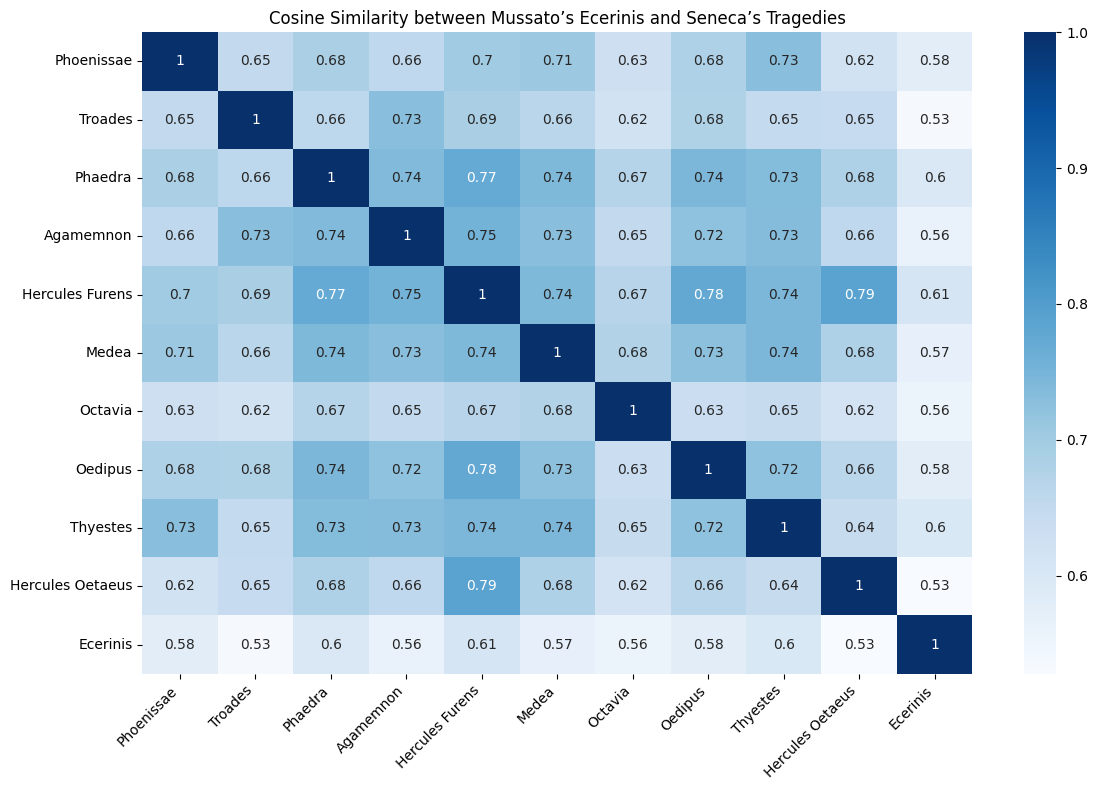

In [44]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
similarity_matrix = cosine_similarity(count_matrix) #calculating cosine similarity between texts

labels = [tragedy["title"] for tragedy in processed_corpus] #labeling all texts

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(similarity_matrix, annot=True, xticklabels=labels, yticklabels=labels, cmap='Blues', cbar=True)
plt.title('Cosine Similarity between Mussato’s Ecerinis and Seneca’s Tragedies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("./figures/new_cosine_similarity_heatmap.png", dpi=300)  # Save the figure
plt.show()